# Evolutionary Strategies

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://rl-vs.github.io/rlvs2021/">https://rl-vs.github.io/rlvs2021/</a>

## Overview

1. [$(1 + \lambda)$ ES](#oneplus)
2. [Approximating the gradient](#gradient)
3. [ES for Neuroevolution](#neuroevolution)
4. [Canonical ES](#canonical)
5. [CMA-ES](#cmaes)

# <a name="oneplus">1.</a> The $(1 + \lambda)$ ES

The simplest Evolutionary Strategy is the $(1+1)$. In this algorithm, the best individual generated is replaced by a new individual when its **fitness** is superior to the current best.

    Initialize x randomly in ℝ
    while not terminate
        x' = x + 𝑁(0, 1)
        if f(x′) < f(x)
            x = x'
    return x

In this algorithm, at each step, we randomly sample from a Normal distribution to get one new point near the current point. However, to better inform the movement from this initial point, we could sample multiple points instead of a single one. We'll first look at examples of continuous functions, as their search space is easier to visualize.

In [1]:
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
import numpy as np
import math

In [3]:
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = himmelblau(X, Y)

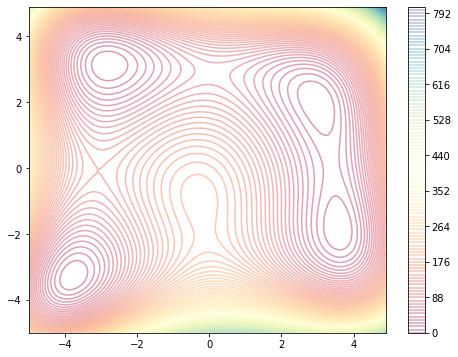

In [4]:
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral',
                 norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
fig.colorbar(cs)
plt.show()

We'll start with a random point $x$. We'll then use a Normal distribution to draw 20 points around $x$.

position:  [ 0.36780829 -0.91428955] fitness : 172.34170007319182


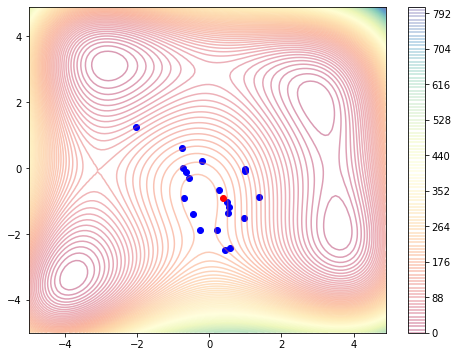

In [5]:
x = np.random.rand(2) * 4 - 2
print("position: ", x, "fitness :", himmelblau(x[0], x[1]))
x_t = np.array([x + np.random.normal(size=(2,)) for i in range(20)])
fig = plt.figure(figsize=(8, 6))
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()), alpha=0.4)
plt.scatter(x_t[:, 0], x_t[:, 1], c='b')
plt.scatter(x[0], x[1], c='r')
fig.colorbar(cs);

Having this population of points will enable us to explore the space around $x$ before moving on to the next step, which can better inform movement in the search space. However, these points might overlap or cover spaces that have already been explored. Generating too many points could slow down search, requiring more evaluations of the objective function. In many applications, that is costly.

Performing random optimization but sampling more than 1 point leads to the $(1+\lambda)$ Evolutionary Strategy. 

    Initialize x randomly in ℝ
    while not terminate
        x_p = x
        for i in [1,λ]
            x_i = x_p + 𝑁(0, 1)
            if f(x_i) < f(x)
                x = x_i
        x_p = x
    return x_p

In the scope of evolutionary algorithms, we'll refer to $x$ as a parent and all $x'$ points as offspring. Each point can also be referred to as an individual in a population, and $f(x)$ is called the fitness of the individual. Each iteration of the algorithm is called a generation.

<div class="alert alert-info">

The $(\mu/\rho,\lambda)$ or $(\mu/\rho+\lambda)$ notation signifies the configuration of parents and offspring. In this notation, $\mu$ is the number of parents, $\rho$ is the number of parents involved in creating the offspring, and $\lambda$ is the number of offspring. $(\mu/\rho+\lambda)$ means the parents can be included in the next population, whereas $(\mu/\rho,\lambda)$ means the parents are not included. $(1+\lambda)$ therefore means that 1 parent is involved in creating a population of $\lambda$ offspring and can be included in the next generation (ie, if $f(x) < f(x') \forall x'$, $x$ does not change).
    
</div>

In [6]:
def oneplus_lambda(x, fitness, gens=100, lam=20):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        for i in range(lam):
            ind = x + N[i, :]
            f = fitness(ind)
            if f < f_best:
                f_best = f
                x_best = ind
        x = x_best
        fits[g] = f_best
    return fits

Let's run the $(1+\lambda)$ ES on the himmelblau function and record the evolution over multiple trials.

In [7]:
f = lambda x : himmelblau(x[0], x[1])
runs = []
for i in range(5):
    x = np.random.rand(2)*10-5
    runs += [oneplus_lambda(x, f)]
runs = np.array(runs)
runs_mean = np.mean(runs, 0)
runs_std = np.std(runs, 0)

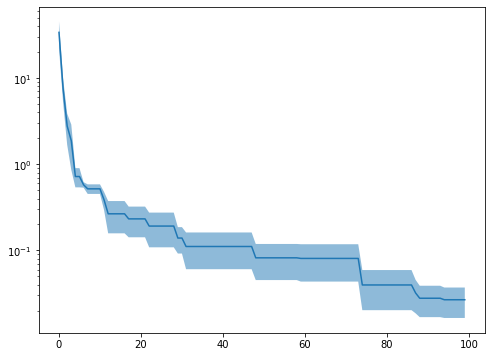

In [8]:
fig = plt.figure(figsize=(8, 6))
plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
plt.plot(range(len(runs[0])), runs_mean)
plt.yscale('log')

# <a name="gradient">2.</a> Approximating the gradient

In the $(1+\lambda)$ ES, we move from the best point in a population to the best point in the next randomly sampled population. However, with the population information, we can do better than that; we can move in the direction of the gradient approximated by the fitness values of the population. This can also better use the full population information, combining all fitness information instead of selecting the best fitness value.

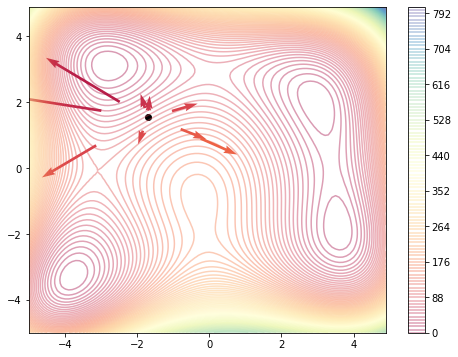

In [9]:
x = np.random.rand(2) * 4 - 2
x_t = np.array([x + np.random.normal(size=(2,)) for i in range(10)])
fits = himmelblau(x_t[:, 0], x_t[:, 1])

fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

First we normalize all fitness values by the average $\mu(f(x))$ and standard deviation $\sigma(f(x))$ of the population. This is to make the movement based on the relative fitness in the population as opposed to the absolute fitness in the search space.

$A = \frac{f(x) - \mu(f(x))}{\sigma(f(x))}$

We'll then define a vector at each point, $x_i - x$. Note that since $x_i = x + N(0, 1)$, we could store just this original random sampled point from $N(0, 1)$ as our vector.

$N_i = x_i - x$

We multiply $A$ by all individual vectors which scales the vector magnitude by the relative fitness. Finally, we sum all vectors and divide by $\lambda$ to get the weighted average.

$\frac{1}{\lambda}\sum_i A_i N_i$

This is equivalent to the dot product and is used as our gradient approximation. Since we're minimizing, we'll use the negative value to do gradient descent.

$\nabla f \approx -\frac{A \cdot N}{\lambda}$

In [10]:
A = (fits - np.mean(fits)) / np.std(fits)
N = x_t - x
G = -np.dot(A, N) / 10

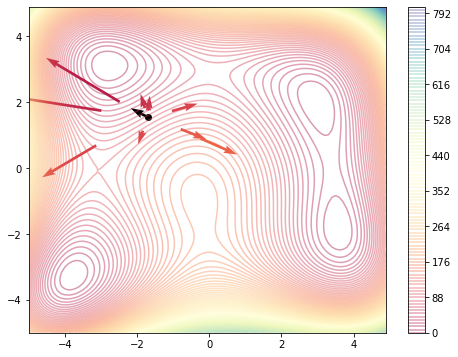

In [11]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm)
plt.quiver(x[0], x[1], G[0], G[1])
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

We have our approximate gradient direction, but how far should we move in it? We'll define a learning rate variable $\alpha$ as the fixed magnitude of movement for now, so our update of $x$ is then

$x = x - \alpha\frac{A \cdot N}{\lambda}$

Let's put this all together as an Evolutionary Strategy. It is a $(\mu, \lambda)$ ES as multiple individuals $\mu$ inform the next generation; however, these individuals are not kept for the next generation.

    Initialize x randomly in ℝ
    while not terminate
        for i in [1,λ]
            N_i = 𝑁(0, 1)
            F_i = f(x + N_i)
        A = (F−𝜇(F))/𝜎(F)
        x = x - 𝛼(A⋅N)/𝜆

In [12]:
def mu_lambda(x, fitness, gens=200, lam=10, alpha=0.2, verbose=False):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        F = np.zeros(lam)
        for i in range(lam):
            ind = x + N[i, :]
            F[i] = fitness(ind)
            if F[i] < f_best:
                f_best = F[i]
                x_best = ind
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        mu_f = np.mean(F)
        std_f = np.std(F)
        A = F
        if std_f != 0:
            A = (F - mu_f) / std_f
        x = x - alpha * np.dot(A, N) / lam
    return fits, x_best

In [13]:
runs = []
for i in range(5):
    x = np.random.randn(2)
    fits, _ = mu_lambda(x, f)
    runs += [fits]
runs = np.array(runs)
runs_mean = np.mean(runs, 0)
runs_std = np.std(runs, 0)

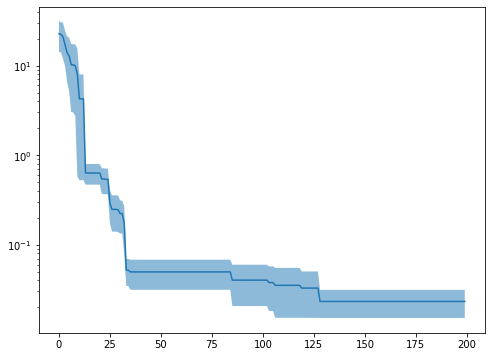

In [14]:
fig = plt.figure(figsize=(8, 6))
plt.fill_between(range(len(runs[0])), runs_mean+0.5*runs_std, runs_mean-0.5*runs_std, alpha=0.5)
plt.plot(range(len(runs[0])), runs_mean)
plt.yscale('log')

# <a name="neuroevolution">3.</a> ES for Neuroevolution

Evolutionary strategies are intended for continuous optimization and can easily be applied to the optimization of neural network parameters, or *neuroevolution*. 

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import gym

In [16]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 32)
        self.l2 = nn.Linear(32, 32)
        self.lout = nn.Linear(32, n_actions)
        
    def forward(self, x):
        x = F.relu(self.l1(x.float()))
        x = F.relu(self.l2(x))
        return self.lout(x)
    
    def get_params(self):
        p = np.empty((0,))
        for n in self.parameters():
            p = np.append(p, n.flatten().cpu().detach().numpy())
        return p
    
    def set_params(self, x):
        start = 0
        for p in self.parameters():
            e = start + np.prod(p.shape)
            p.data = torch.FloatTensor(x[start:e]).reshape(p.shape)
            start = e

We'll add some visualization functionality to have the environment render directly in the notebook. To run this notebook in Google colab, uncomment and run the following lines.

In [17]:
#!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [18]:
#!pip install pyvirtualdisplay

In [19]:
from pyvirtualdisplay import Display
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
pydisplay = Display(visible=0, size=(1400, 900))
pydisplay.start()
plt.ion();

Following the framework of evolutionary policy search, we will optimize a neural network representing a policy and maximize the total reward over a single episode using this policy.

In [20]:
def evaluate(ann, env, visul=True):
    env.seed(0) # deterministic for demonstration
    obs = env.reset()
    if visul:
        img = plt.imshow(env.render(mode='rgb_array'))
    total_reward = 0
    while True:
        # Output of the neural net
        net_output = ann(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if visul:
            img.set_data(env.render(mode='rgb_array')) 
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if done:
            break
    return total_reward

We've configured this for discrete action spaces. We can see a random neural network on different environments like `CartPole-v0`, `MountainCar-v0`, and `LunarLander-v2`.

In [21]:
env = gym.make('LunarLander-v2')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

-811.9250644938041

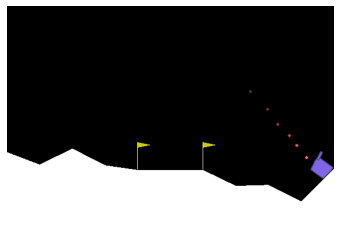

In [22]:
evaluate(ann, env, visul=True)

In order to evolve the parameters of this neural network, we will modify the parameters of the network using `set_params` with the genes of the new individual. In the evolutionary literature, this is referred to as a *direct encoding* as the neural network parameters are directly encoded in the genome.

In [23]:
def fitness(x, ann, env, visul=False):
    ann.set_params(x)
    return -evaluate(ann, env, visul=visul)

In [24]:
p = ann.get_params()
np.shape(p)

(1476,)

We can first observe a random individual $x$.

-480.84488673788087

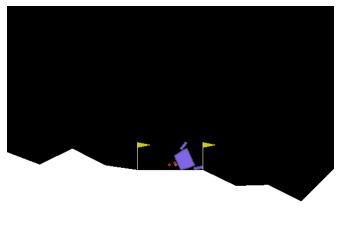

In [25]:
x = np.random.rand(len(p))
-fitness(x, ann, env, visul=True)

In [26]:
np.random.seed(654)
env = gym.make('LunarLander-v2')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
x = np.random.randn(len(ann.get_params()))
f = lambda x : fitness(x, ann, env)
fits, x = mu_lambda(x, f, gens=30, lam=10, alpha=0.1, verbose=True)

0   206.1899952892575
0   116.6922372247762
1   26.70887857740935
22   21.095921017793017


-21.095921017793017

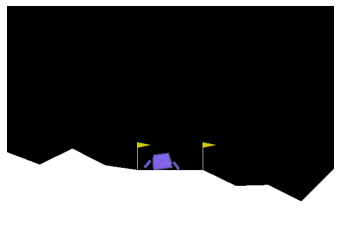

In [27]:
-fitness(x, ann, env, visul=True)

# <a name="canonical">4.</a> Canonical ES

We can make two observations about our current $(\mu, \lambda)$ Evolutionary Strategy:

1. Not all $\lambda$ points may be useful for the centroid update
2. Exact gradient information may be less useful than relative *rank* of individual fitness

Let's illustrate this point in the Himmelblau function. Instead of using all $\lambda$ points, we'll use a smaller value of $\mu$, for example $\frac{1}{2}\lambda$. We'll also create a list of weights which exponentially decreases from the first to last weight.

In [28]:
mu = 5
w = np.log(mu + 1/2) - np.log(np.arange(1, mu+1))
w /= np.sum(w)
w

array([0.45627265, 0.2707531 , 0.16223112, 0.08523355, 0.02550959])

As before, we create a random starting point and then add Gaussian noise to create offspring.

In [29]:
np.random.seed(123)
x = np.random.rand(2) * 4 - 2
N = np.random.normal(size=(10,2))
x_t = x + N
fits = himmelblau(x_t[:, 0], x_t[:, 1])
fits

array([149.43579676, 141.1815117 , 140.88616568,  76.38774424,
       178.41541966,  59.61119289, 173.12493856,   5.5135972 ,
        93.21569448,  90.44989743])

Now, however, instead of directly using fitness values, we'll select the best individuals and update using their weighted values.

In [30]:
sorted_ids = np.argsort(fits)
weighted = N[sorted_ids[:mu]] * w.reshape(mu, 1)
weighted

array([[ 1.00650556,  0.99777068],
       [ 0.40379836, -0.17298469],
       [ 0.20537425, -0.14061226],
       [ 0.06284854,  0.12706038],
       [ 0.02561301,  0.00985146]])

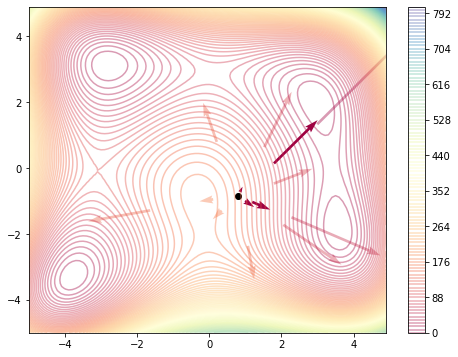

In [31]:
fig = plt.figure(figsize=(8, 6))
norm = colors.Normalize(vmin=Z.min(), vmax=Z.max())
cs = plt.contour(X, Y, Z, levels=100, cmap='Spectral', alpha=0.4, norm=norm)
plt.quiver(x_t[:, 0], x_t[:, 1], x_t[:, 0]-x[0], x_t[:, 1]-x[1],
           fits, scale=fits/100, scale_units='xy', cmap='Spectral', norm=norm, alpha=0.4)
plt.quiver(x[0]+weighted[:, 0], x[1]+weighted[:, 1], weighted[:, 0], weighted[:, 1],
           w, scale_units='xy', cmap='Spectral', norm=norm)
plt.scatter(x[0], x[1], c='k')
fig.colorbar(cs)
plt.show()

The first point is clear: using all points in the centroid update could pull it away from nearby optima. The second point is a bit harder to understand, but motivation is this: any transformation to the search space which **preserves rank** for the top $\mu$ individuals does not change the update. This invariance property is helpful to search because it increases the predictive power of the fitness by inducing problem equivalence classes.

Hansen, N., Ros, R., Mauny, N., Schoenauer, M., & Auger, A. (2011). Impacts of invariance in search: When CMA-ES and PSO face ill-conditioned and non-separable problems. Applied Soft Computing, 11(8), 5755-5769.

Incorporating these two changes to the previous $(\mu, \lambda)$ ES brings us an ES referred to as Canonical ES

<img src="imgs/canonical.png" width="40%" height="auto">

Chrabaszcz, P., Loshchilov, I., & Hutter, F. (2018, July). Back to basics: benchmarking canonical evolution strategies for playing Atari. In Proceedings of the 27th International Joint Conference on Artificial Intelligence (pp. 1419-1426). [code](https://github.com/PatrykChrabaszcz/Canonical_ES_Atari)

<img src="imgs/canonical_results.png" width="80%" height="auto">

<div class="alert alert-warning">

<h3>Embarrassingly parallel ES</h3>

All ES examples we've seen so far use sequential evaluation of individuals in a single thread. However, evaluations can be done entirely in parallel. Evaluation is by far the most computationally expensive part of the algorith and the fact that it is embarrassingly parallel means that the wall clock time of evolutionary algorithms in general can be greatly reduced by parallelizing over multiple threads.
    
</div>

# <a name="cmaes">5.</a> Covariance Matrix Adaptation Evolutionary Strategy

Covariance Matrix Adaptation Evolutionary Strategy, or CMA-ES [1, 2], is one of the most well-known evolutionary algorithms in general and is a state-of-the-art algorithm for continuous optimization. The strength of this method is that it adapts the distribution it uses to generate the next population based on the current distribution of individuals. Until now, we were limited to a Normal distribution with a static $\sigma$. The adaptive distribution of CMA-ES means it will cross search spaces faster and narrow in more exactly on optimal points.

[1] Hansen, Nikolaus, and Andreas Ostermeier. "Adapting arbitrary normal mutation distributions in evolution strategies: The covariance matrix adaptation." Proceedings of IEEE international conference on evolutionary computation. IEEE, 1996.

[2] Hansen, Nikolaus, and Andreas Ostermeier. "Completely derandomized self-adaptation in evolution strategies." Evolutionary computation 9.2 (2001): 159-195.

Specifically, the things that CMA-ES improves over the previous Evolutionary Strategies we've seen is that it:
+ combines information from multiple individuals (as in $(\mu, \lambda)$ and Canonical ES)
+ combines information from multiple generations
+ transforms the distribution of the new population to match the search space
+ adapts the step size to prevent premature convergence

One improvement in CMA-ES which we've already seen is the use of **fitness rank** instead of direct fitness for the update. However, instead of directly updating a centroid, CMA-ES updates a covariance matrix.

<img src="imgs/cmaes.png">

To see CMA-ES in practice, we'll use the pycma package (https://github.com/CMA-ES/pycma). If you haven't installed it, do so here:

In [32]:
!pip install cma

`pycma` is actively maintained by the CMA-ES author and has many more algorithm tricks and features than we've discussed here. [4] provides a good review of different CMA-ES modifications.

[4] Hansen, Nikolaus. "The CMA evolution strategy: a comparing review." Towards a new evolutionary computation. Springer, Berlin, Heidelberg, 2006. 75-102.

In [33]:
import cma
np.random.seed(123)
env = gym.make('LunarLander-v2')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.1, {'seed': 123})

(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 1476 (seed=123, Thu Apr  8 05:51:31 2021)


In [34]:
for i in range(20):
    solutions = np.array(es.ask())
    fits = [fitness(x, ann, env) for x in solutions]
    es.tell(solutions, fits)
    es.disp()

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 9.187798469390201e+01 1.0e+00 9.95e-02  1e-01  1e-01 0:00.9
    2     50 1.191263652886890e+02 1.0e+00 9.89e-02  1e-01  1e-01 0:01.6
    3     75 1.191263652886890e+02 1.0e+00 9.84e-02  1e-01  1e-01 0:02.4
    7    175 4.540438390999863e+01 1.0e+00 9.67e-02  1e-01  1e-01 0:05.5
   12    300 1.126875558128404e-04 1.0e+00 9.47e-02  9e-02  9e-02 0:10.0
   17    425 -2.404945469949255e+02 1.0e+00 9.30e-02  9e-02  9e-02 0:15.7


240.49454699492554

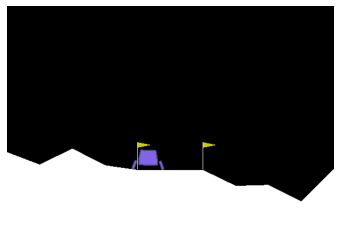

In [35]:
x = es.result[0]
-fitness(x, ann, env, visul=True)

The results on LunarLander clearly show the benefits of CMA-ES; we have found a reasonable policy in a small number of generations. Applying CMA-ES to larger neural networks remains an open challenge, however, due to the vast number of parameters in ANNs. Specifically, CMA-ES calculates the covariance of all parameters, which is $O(n^2)$.

In [36]:
np.shape(es.sm.C)

(1476, 1476)